In [1]:
import numpy as np
import pandas as pd
peaks = pd.read_csv('combined_peaks_named.csv')

biotic_peaks = peaks[peaks['class'] == 1][['RT1_center','RT2_center','m/z']].to_numpy()
abiotic_peaks = peaks[peaks['class'] == 0][['RT1_center','RT2_center','m/z']].to_numpy()

biotic_peaks

array([[9.7090720e+03, 1.9440000e+00, 2.2300000e+02],
       [7.5681280e+03, 1.4800000e+00, 2.2300000e+02],
       [7.8799840e+03, 1.5040000e+00, 2.3700000e+02],
       ...,
       [1.0006912e+04, 1.0400000e+00, 2.0600000e+02],
       [9.2395360e+03, 1.2000000e+00, 2.0600000e+02],
       [1.0550032e+04, 1.8320000e+00, 2.0600000e+02]])

In [2]:
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy.optimize import approx_fprime
from sklearn.preprocessing import RobustScaler, StandardScaler, MaxAbsScaler

def log_density_function(kde):
    def log_density(point):
        return kde.score_samples(point.reshape(1, -1))[0]
    return log_density

def gradient_descent_kde(df):
    abiotic_peaks = df[df['class'] == 0]
    biotic_peaks = df[df['class'] == 1]

    # Create a dataframe including both retention times and mass/charge
    features_all = df[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
    features_abiotic_ = abiotic_peaks[['RT1_center', 'RT2_center', 'm/z']].to_numpy()
    features_biotic_ = biotic_peaks[['RT1_center', 'RT2_center', 'm/z']].to_numpy()

    # Normalize features for gradient calculation
    scaler = StandardScaler()
    scaler.fit(features_all)
    biotic_peaks_normalized = scaler.transform(features_biotic_)
    abiotic_peaks_normalized = scaler.transform(features_abiotic_)

    # params = {'bandwidth': np.logspace(-1, 1, 20)}
    # grid = GridSearchCV(KernelDensity(), params, cv=5)
    # grid.fit(biotic_peaks_normalized)

    # optimal_kde = grid.best_estimator_
    # print('Optimal bandwidth: ', optimal_kde.bandwidth)

    optimal_kde = KernelDensity(kernel='gaussian', bandwidth='scott')
    optimal_kde.fit(biotic_peaks_normalized)

    rt1 = [features_abiotic_[:, 0]]
    rt2 = [features_abiotic_[:, 1]]
    mz = [features_abiotic_[:, 2]]
    grad_rt1 = []
    grad_rt2 = []
    grad_mz = []

    features = abiotic_peaks_normalized

    # 'Learning' rate - controls how influential gradients are
    alpha = 1

    time_steps = 50
    for t in range(time_steps):
        gradients = []
        # Calculate the gradient at each point based on the log density
        for j in range(len(features)):
            log_density_func = log_density_function(optimal_kde)
            grad = approx_fprime(features[j, :], log_density_func)

            # Prevent exploding gradients due to approximation error
            grad = grad / 100
            grad = np.clip(grad, -10, 10)
            gradients.append(grad)

            # Move each point to new location
            features[j, :] -= (alpha / ((t + 1) * 2)) * grad

        gradients = np.array(gradients)

        original_features = scaler.inverse_transform(features)

        # Convert updated features back to original scale
        rt1.append(original_features[:, 0])
        rt2.append(original_features[:, 1])
        mz.append(original_features[:, 2])

        # Save gradients for later analysis
        grad_rt1.append(gradients[:, 0])
        grad_rt2.append(gradients[:, 1])
        grad_mz.append(gradients[:, 2])

    return {
        'rt1': np.array(rt1),
        'rt2': np.array(rt2),
        'mz': np.array(mz),
        'grad_rt1': np.array(grad_rt1),
        'grad_rt2': np.array(grad_rt2),
        'grad_mz': np.array(grad_mz)
    }

peaks = pd.read_csv('combined_peaks_named.csv')
gradient_dict = gradient_descent_kde(peaks)

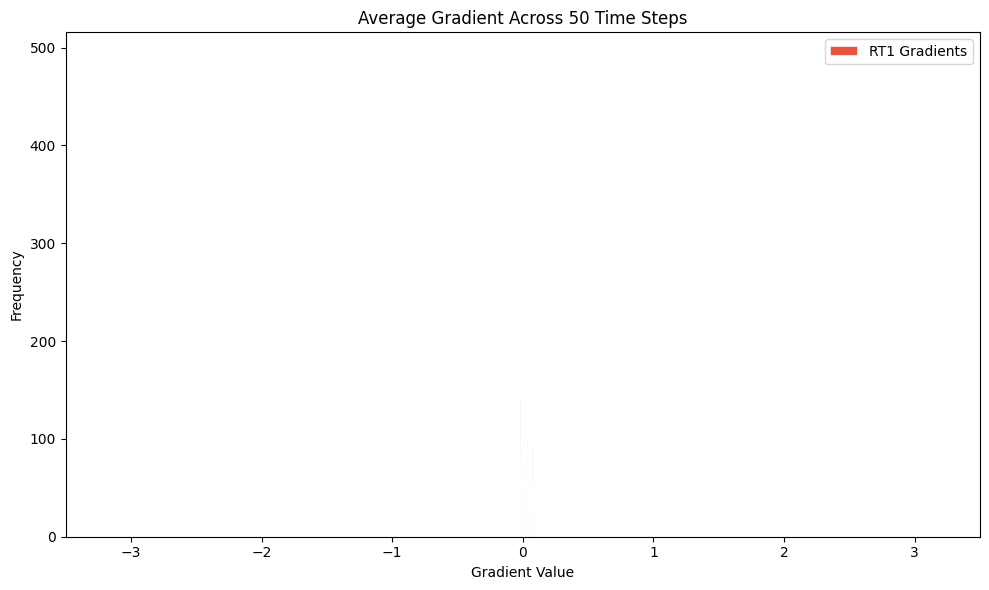

In [3]:
import matplotlib.pyplot as plt

def plot_overlapping_average_gradient(grad_rt1, grad_rt2, grad_mz):
    # Concatenate gradient arrays
    data_rt1 = np.concatenate(grad_rt1)
    data_rt2 = np.concatenate(grad_rt2)
    data_mz = np.concatenate(grad_mz)

    # Compute average values
    avg_rt1 = np.mean(data_rt1)
    avg_rt2 = np.mean(data_rt2)
    avg_mz = np.mean(data_mz)

    palette = ['#e64b35','#3c5488','#9E3DFF']

    # Prepare data for plotting
    data = [
        (data_rt1, avg_rt1, 'RT1 Gradients', palette[0]),
        # (data_rt2, avg_rt2, 'RT2 Gradients', 'mediumseagreen'),
        # (data_mz, avg_mz, 'M/Z Gradients', palette[1])
    ]

    # Sort data by average value to plot higher averages last
    data.sort(key=lambda x: x[1])

    plt.figure(figsize=(10, 6))

    # Plot histograms in the sorted order
    for values, avg, label, color in data:
        plt.hist(values, bins=300, color=color, alpha=0.95, label=label, edgecolor='white', linewidth=1.2)

    # Customize the plot
    plt.title('Average Gradient Across 50 Time Steps')
    plt.xlabel('Gradient Value')
    plt.ylabel('Frequency')
    plt.xlim([-3.5, 3.5])
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(False)
    #plt.savefig('average_gradients.pdf', dpi=300)
    plt.show()

grad_rt1 = gradient_dict['grad_rt1']
grad_rt2 = gradient_dict['grad_rt2']
grad_mz = gradient_dict['grad_mz']
plot_overlapping_average_gradient(grad_rt1, grad_rt2, grad_mz)

In [4]:
grad_rt1 = gradient_dict['grad_rt1'][0]
grad_rt2 = gradient_dict['grad_rt2'][1]
grad_mz = gradient_dict['grad_mz'][2]
scaled_gradients = np.column_stack((grad_rt1, grad_rt2, grad_mz))

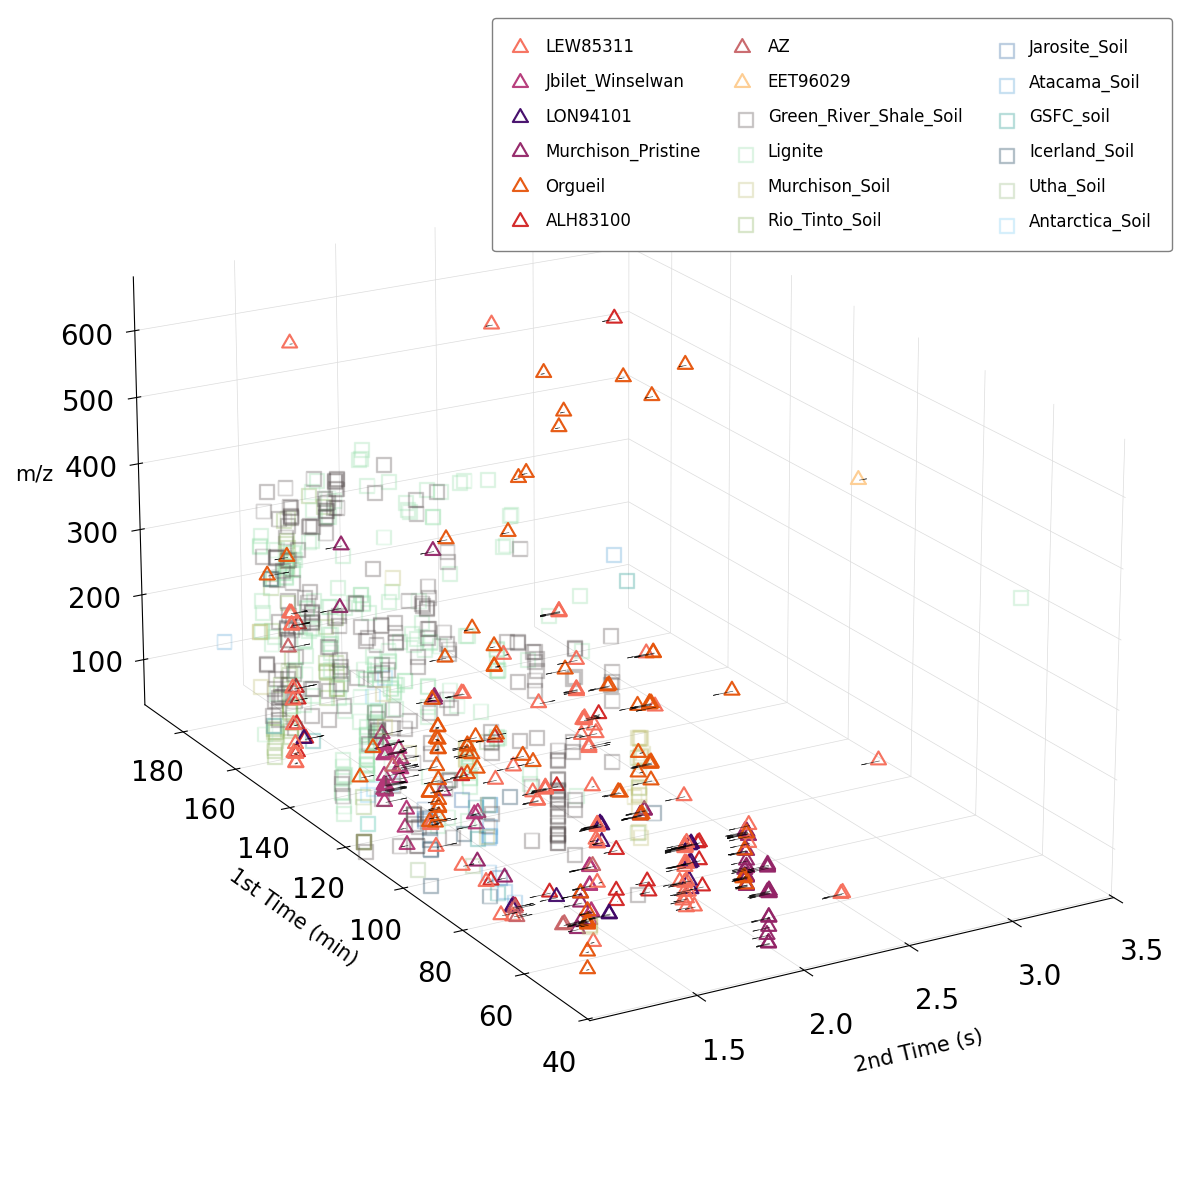

In [5]:
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import random
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.markers import MarkerStyle

def get_marker(svg_path):
    cwd = os.getcwd()
    custom_path, attributes = svg2paths(svg_path)
    marker = parse_path(attributes[0]['d'])
    marker.vertices -= marker.vertices.mean(axis=0)
    marker = marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
    marker = marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    return marker

def plot_peak_gradients(peaks_features_df, samples, df1, gradients, result_dir, view='small'):
    peaks_features_df = peaks_features_df.copy()

    # Set up markers
    oval = Path([(1,-1), (-1,-1), (-1,1), (1,1), (1,-1)], [Path.MOVETO, Path.CURVE3, Path.LINETO, Path.CURVE3, Path.LINETO])

    hollow_square = get_marker('markers/geometry-shape-square-figure-form-graphic-svgrepo-com.svg')
    triangle_marker = get_marker('markers/triangle-svgrepo-com.svg')

    markers_biotic = [hollow_square]*10
    colors_biotic = ["#595051", "#9be1af", "#c3c378", "#8cb45f", "#366ea5",
                     "#5aa5d7", "#279b91", "#143c55", "#9bbe87", "#82d2f5"]

    markers_abiotic = [triangle_marker]*8
    colors_abiotic = ["#f66e5b","#b53778","#410868","#932467","#e6550c","#d22323","#c86468","#fdcc90"]

    fig = plt.figure(figsize=(24, 24) if view != 'small' else (12, 12))
    ax = fig.add_subplot(111, projection='3d')
    plt.tight_layout()

    # Plot each class
    for class_id, markers, colors in zip([0, 1], [markers_abiotic, markers_biotic], [colors_abiotic, colors_biotic]):
        class_samples = samples[samples['class'] == class_id]['sample_name'].unique()
        for i, sample in enumerate(class_samples):
            sample_df = peaks_features_df[(peaks_features_df['sample_name'] == sample) & (peaks_features_df['class'] == class_id)]
            if class_id == 1:
                alpha = 0.23
                colors = colors_biotic
            else:
                alpha = 0.9
                colors = colors_abiotic
            if class_id == 1:
                size = 200
            else:
                size = 200

            ax.scatter(
                sample_df['RT2_center'],
                sample_df['RT1_center'] / 60.0,
                sample_df['m/z'],
                c=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                s=size,
                alpha=alpha,
                edgecolors=colors[i % len(colors)],
                label=f'{sample}'
            )

    quiver_scale = 0.1 if view == "small" else 7
    quiver_kwargs = dict(length=quiver_scale, normalize=True, colors="black", linewidth=0.45, edgecolors='k', alpha=0.7)
    ax.quiver(df1['RT2_center'], df1['RT1_center'] / 60.0, df1['m/z'],
              scaled_gradients[:, 1], scaled_gradients[:, 0] / 60.0, scaled_gradients[:, 2],
              **quiver_kwargs)

    # Set labels, ticks, and view
    ax.set_xlabel('2nd Time (s)', labelpad=30, fontsize=15)
    ax.set_ylabel('1st Time (min)', labelpad=30, fontsize=15)
    ax.set_zlabel('m/z', labelpad=30, fontsize=15)

    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.tick_params(axis='x', which='major', pad=15)
    ax.tick_params(axis='y', which='major', pad=15)
    ax.tick_params(axis='z', which='major', pad=15)

    ax.view_init(elev=20, azim=-120 if view == 'small' else -160)
    ax.set_box_aspect([2.5, 4, 2] if view == 'small' else [3, 4, 2])

    plt.gcf().set_facecolor('white')
    plt.gca().set_facecolor('white')
    ax.xaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-' , linewidth=0.5)
    ax.yaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)
    ax.zaxis._axinfo['grid'].update(color = '#dcdcdc', linestyle = '-', linewidth=0.5)

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ax.legend(handletextpad = 1, fontsize='12', title_fontsize='14', handlelength=1, loc='upper right', borderpad=1.2, labelspacing=1, frameon=True, framealpha=1, edgecolor='gray', facecolor='white', ncol=3)

    ax.set_xlim(peaks_features_df['RT2_center'].min(), 3.5)
    #ax.set_ylim(peaks_features_df['RT1_center'].min(), 190)
    ax.set_zlim(peaks_features_df['m/z'].min(), 680)
    #plt.tight_layout()
    # Uncomment the line below to save the figure
    plt.savefig('peak_gradients_figure.pdf', dpi=300)
    plt.show()
    plt.close()

abiotic_peaks = peaks[peaks['class'] == 0]
plot_peak_gradients(peaks, peaks, abiotic_peaks, scaled_gradients, '/content/', view='small')

In [6]:
def restructure_data(rt1, rt2, mz):
    n_points = len(rt1[0])
    n_timesteps = len(rt1)

    data = {
        'RT1': np.array(rt1).flatten(),
        'RT2': np.array(rt2).flatten(),
        'MZ': np.array(mz).flatten(),
        'TimeStep': np.repeat(range(n_timesteps), n_points),
        'Point': np.tile(range(n_points), n_timesteps)
    }

    return pd.DataFrame(data)

# Restructure the data
rt1 = gradient_dict['rt1']
rt2 = gradient_dict['rt2']
mz = gradient_dict['mz']
df_restructured = restructure_data(rt1, rt2, mz)

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff as timeseries_diff
import warnings
warnings.filterwarnings('ignore')

def check_stationarity_and_difference(data, max_diff=5, significance_level=0.05):
    """Check and make the data stationary by differencing up to max_diff times."""
    original_length = len(data)
    for i in range(max_diff + 1):
        if i > 0:
            data = timeseries_diff(data, k_diff=1)
        adf_result = adfuller(data, autolag='AIC')
        p_value = adf_result[1]
        if p_value < significance_level:
            return data, original_length - len(data)  # Return differenced data and the reduction in length
    return data, original_length - len(data)  # If not stationary, return the differenced data

def granger_causality_for_point(data, max_lag=2):
    try:
        result = grangercausalitytests(data, maxlag=max_lag, verbose=False)
        p_values = [result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag+1)]
        f_stats = [result[lag][0]['ssr_ftest'][0] for lag in range(1, max_lag+1)]
        min_p_value = min(p_values)
        best_lag = p_values.index(min_p_value) + 1
        max_f_stat = max(f_stats)
        return min_p_value, best_lag, max_f_stat
    except:
        return np.nan, np.nan, np.nan


def prepare_and_test_granger(df_restructured, max_lag=2):
    results = []
    for point in range(df_restructured['Point'].max() + 1):
        point_data = df_restructured[df_restructured['Point'] == point].sort_values('TimeStep')

        rt1_stationary, rt1_diff = check_stationarity_and_difference(point_data['RT1'].values)
        rt2_stationary, rt2_diff = check_stationarity_and_difference(point_data['RT2'].values)
        mz_stationary, mz_diff = check_stationarity_and_difference(point_data['MZ'].values)

        # Find the minimum length to truncate the series uniformly
        min_length = min(len(rt1_stationary), len(rt2_stationary), len(mz_stationary))
        rt1_stationary = rt1_stationary[:min_length]
        rt2_stationary = rt2_stationary[:min_length]
        mz_stationary = mz_stationary[:min_length]

        # Create stationary arrays suitable for Granger testing
        data_rt1_rt2 = np.column_stack((rt1_stationary, rt2_stationary))
        data_rt1_mz = np.column_stack((rt1_stationary, mz_stationary))
        data_mz_rt1 = np.column_stack((mz_stationary, rt1_stationary))
        data_mz_rt2 = np.column_stack((mz_stationary, rt2_stationary))
        data_rt2_rt1 = np.column_stack((rt2_stationary, rt1_stationary))
        data_rt2_mz = np.column_stack((rt2_stationary, mz_stationary))

        # Run Granger causality tests
        p_rt1_rt2, lag_rt1_rt2, f_rt1_rt2 = granger_causality_for_point(data_rt1_rt2, max_lag)
        p_rt1_mz, lag_rt1_mz, f_rt1_mz = granger_causality_for_point(data_rt1_mz, max_lag)
        p_mz_rt2, lag_mz_rt2, f_mz_rt2 = granger_causality_for_point(data_mz_rt2, max_lag)
        p_mz_rt1, lag_mz_rt1, f_mz_rt1 = granger_causality_for_point(data_mz_rt1, max_lag)
        p_rt2_rt1, lag_rt2_rt1, f_rt2_rt1 = granger_causality_for_point(data_rt2_rt1, max_lag)
        p_rt2_mz, lag_rt2_mz, f_rt2_mz = granger_causality_for_point(data_rt2_mz, max_lag)

        results.append((p_rt1_rt2, lag_rt1_rt2, f_rt1_rt2,
                        p_rt1_mz, lag_rt1_mz, f_rt1_mz,
                        p_mz_rt2, lag_mz_rt2, f_mz_rt2,
                        p_mz_rt1, lag_mz_rt1, f_mz_rt1,
                        p_rt2_rt1, lag_rt2_rt1, f_rt2_rt1,
                        p_rt2_mz, lag_rt2_mz, f_rt2_mz))

    results_df = pd.DataFrame(results, columns=['P_RT1_RT2', 'Lag_RT1_RT2', 'F_RT1_RT2',
                                                'P_RT1_MZ', 'Lag_RT1_MZ', 'F_RT1_MZ',
                                                'P_MZ_RT2', 'Lag_MZ_RT2', 'F_MZ_RT2',
                                                'P_MZ_RT1', 'Lag_MZ_RT1', 'F_MZ_RT1',
                                                'P_RT2_RT1', 'Lag_RT2_RT1', 'F_RT2_RT1',
                                                'P_RT2_MZ', 'Lag_RT2_MZ', 'F_RT2_MZ'])
    return results_df

# Example usage:
results_df = prepare_and_test_granger(df_restructured)


print("\nSummary of Granger Causality Tests:")
for relation in ['RT1_RT2', 'MZ_RT2', 'RT2_RT1', 'RT2_MZ']:
    sig_count = sum(results_df[f'P_{relation}'] < 0.05)
    avg_lag = results_df[f'Lag_{relation}'].mean()
    avg_f = results_df[f'F_{relation}'].mean()
    print(f"\n{relation}:")
    print(f"Significant tests: {sig_count}/{len(results_df)}")
    print(f"Average best lag: {avg_lag:.2f}")
    print(f"Average max F-statistic: {avg_f:.2f}")

# Compare which relationship has the shortest average lag
lag_comparison = results_df[['Lag_RT1_RT2', 'Lag_RT1_MZ', 'Lag_MZ_RT2', 'Lag_MZ_RT1', 'Lag_RT2_RT1', 'Lag_RT2_MZ']].mean()
print("\nAverage lags:")
print(lag_comparison)
print(f"\nRelationship with shortest average lag: {lag_comparison.idxmin()}")

# Compare which relationship has the highest average F-statistic
f_comparison = results_df[['F_RT1_RT2', 'F_MZ_RT2', 'F_RT2_RT1', 'F_RT2_MZ']].mean()
print("\nAverage F-statistics:")
print(f_comparison)
print(f"\nRelationship with highest average F-statistic: {f_comparison.idxmax()}")


Summary of Granger Causality Tests:

RT1_RT2:
Significant tests: 0/295
Average best lag: nan
Average max F-statistic: nan

MZ_RT2:
Significant tests: 0/295
Average best lag: nan
Average max F-statistic: nan

RT2_RT1:
Significant tests: 0/295
Average best lag: nan
Average max F-statistic: nan

RT2_MZ:
Significant tests: 0/295
Average best lag: nan
Average max F-statistic: nan

Average lags:
Lag_RT1_RT2   NaN
Lag_RT1_MZ    NaN
Lag_MZ_RT2    NaN
Lag_MZ_RT1    NaN
Lag_RT2_RT1   NaN
Lag_RT2_MZ    NaN
dtype: float64

Relationship with shortest average lag: nan

Average F-statistics:
F_RT1_RT2   NaN
F_MZ_RT2    NaN
F_RT2_RT1   NaN
F_RT2_MZ    NaN
dtype: float64

Relationship with highest average F-statistic: nan
